In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
from tensorflow_addons.optimizers.utils import fit_bn

from train import *
from single_model import build_model, val_np_dataset

path = 'jigsaw/tt42f3/20200606_172233_t2d'
gcs = 'hm-eu'
tpu_id = None


## Configuration
#     path = f'{path}/{time.strftime("%Y%m%d_%H%M%S")}_{tpu_id}'
gcs_path = f'gs://{gcs}/{path}'
checkpoint_path = f"{gcs_path}/best_model.tf"
print('gcs_path:', gcs_path)
# params['gcs_path'] = gcs_path


params = tf.io.gfile.glob(f'{gcs_path}/params*.csv')
print(params)
params = params[0]
params = pd.read_csv(params)

kw_params = params.T[0].to_dict()
print(params.T)
gc.collect()

# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)
# os.environ['TF_DETERMINISTIC_OPS'] = '1'

strategy = setup_tpu(tpu_id)

gcs_path: gs://hm-eu/jigsaw/tt42f3/20200606_172233_t2d
['gs://hm-eu/jigsaw/tt42f3/20200606_172233_t2d/params0.963984.csv']
                                                                  0
dual                                                          False
tpu_id                                                          t2d
batch_size                                                       27
max_len                                                         192
seed                                                           7430
path                                                  jigsaw/tt42f3
gcs                                                           hm-eu
dataset           ../input/jigsaw20-ds-tt42-35/jigsaw20_ds180102...
pooling                                                       first
optimizer                                                      LAMB
lr                                                      0.000124374
mom_min                                                      

In [5]:
code = f'{"-".join(gcs_path.split("/")[-3:])}'
code

'jigsaw-tt42f3-20200606_172233_t2d'

In [6]:
ds = '../ds'
!rm -rf {ds}
!mkdir {ds}

## Load and Train
with strategy.scope():
    model = build_model(**kw_params)
    model = compile_model(model, **kw_params)
#     model, preds, sub = train_model(model, strategy, checkpoint_path, **kw_params)

# load best
# latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint_path = f'{gcs_path}/best_model.tf'
with strategy.scope():
    model.load_weights(checkpoint_path)
    model.save_weights(f'{ds}/xlm-r_{code}_{params["auc"].values[0]}.h5')

!gsutil cp {gcs_path}/*.csv {ds}
!gsutil cp {gcs_path}/*.png {ds}
!ls -sh {ds}

total 2,1G
2,1G xlm-r_jigsaw-tt42f3-20200606_172233_t2d_0.9639843402865342.h5


In [14]:
# url = f'hmendonca/{code[:40].replace("_", "-")}'
# cmd = f"""
# cat <<EOF > {ds}/dataset-metadata.json
# {{
#   "title": "{code}",
#   "id": "{url}",
#   "licenses": [{{ "name": "CC0-1.0" }}]
# }}
# EOF
# """
# !eval {cmd}
# !cat {ds}/dataset-metadata.json
# # !kaggle datasets version --dir-mode zip -p {ds} -m 'again'
# !kaggle datasets create -p {ds}

# url

{
  "title": "jigsaw-tt42f3-20200606_172233_t2d",
  "id": "hmendonca/jigsaw-tt42f3-20200606-172233-t2d",
  "licenses": [{ "name": "CC0-1.0" }]
}
Starting upload for file valid_oof.csv
100%|███████████████████████████████████████| 3.12M/3.12M [00:05<00:00, 652kB/s]
Upload successful: valid_oof.csv (3MB)
Starting upload for file xlm-r_jigsaw-tt42f3-20200606_172233_t2d_0.9639843402865342.h5
100%|██████████████████████████████████████| 2.09G/2.09G [09:01<00:00, 4.14MB/s]
Upload successful: xlm-r_jigsaw-tt42f3-20200606_172233_t2d_0.9639843402865342.h5 (2GB)
Starting upload for file sub_hist.png
100%|██████████████████████████████████████| 4.29k/4.29k [00:03<00:00, 1.19kB/s]
Upload successful: sub_hist.png (4KB)
Starting upload for file submission.csv
100%|███████████████████████████████████████| 1.03M/1.03M [00:03<00:00, 294kB/s]
Upload successful: submission.csv (1MB)
Starting upload for file params0.963984.csv
100%|████████████████████████████████████████████| 485/485 [00:03<00:00, 159B/s

'hmendonca/jigsaw-tt42f3-20200606-172233-t2d'

In [6]:
# !rm -rf {ds}

mean: 0.21181340632114404 ratio: 0.18001316366827555


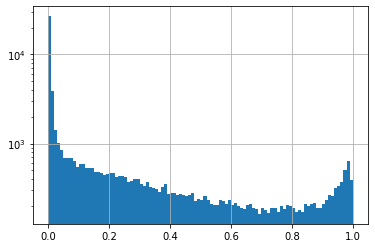

In [7]:
## Load Dataset
comp_ds = '../input/jigsaw-multilingual-toxic-comment-classification'
valid = pd.read_csv(f'{comp_ds}/validation.csv')
#     test = pd.read_csv(f'{comp_ds}/test.csv')
sub = pd.read_csv('../input/jigsaw20-ensemble04-29/submission.csv')

sub.toxic.hist(bins=100, log=True)
print('mean:', sub.toxic.mean(), 'ratio:', (sub.toxic > 0.5).mean())

In [8]:
params.loc[0, "batch_size"]

24

In [9]:
batch_size = 128 #params["batch_size"].values[0] * strategy.num_replicas_in_sync
print('batch_size:', batch_size)

valid_dataset, test_dataset = val_np_dataset(batch_size=batch_size)

# fit_bn(model, valid_dataset)

# preds = model.predict(valid_dataset, verbose=1)
# # sub_y = model.predict(test_dataset, verbose=1)

# valid['pred'] = preds
# valid_auc = roc_auc_score(valid.toxic, valid.pred)
# print('AUC:', valid_auc,
#         'toxic:', valid.toxic.mean(),
#         'pred:', valid.pred.mean(),
#         'ratio:', (valid.pred > 0.5).mean())

batch_size: 128
(8000, 192) (63812, 192) (8000,)


In [10]:
""" load npz datasets """
dataset = '../input/jigsaw20-val-test-ds/jigsaw20_val_ds.npz'
array = np.load(dataset)
x_valid, x_test, y_valid = [array[k] for k in list(array)]
print(x_valid.shape, x_test.shape, y_valid.shape)

# fit_bn(model, x_test, np.ones(len(x_test))*0.5, batch_size=28)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_test, sub.toxic.astype(np.float32)))
    .batch(batch_size)
#     .prefetch(tf.data.experimental.AUTOTUNE)
)

for l in model.layers:
    l.trainable = False
fit_bn(model, test_dataset)

(8000, 192) (63812, 192) (8000,)


/home/henrique/.local/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


499/499 [==============================] - 278s 557ms/step - auc: 0.9382 - loss: 0.2111


In [11]:
preds = model.predict(valid_dataset, verbose=1)
sub_y = model.predict(test_dataset, verbose=1)

499/499 [==============================] - 64s 128ms/step


In [12]:
valid['pred'] = preds
valid.to_csv(f'{gcs_path}/valid_oof_test.csv', index=False)

valid.groupby('toxic').pred.hist(bins=100, log=True, alpha=0.5)
plt.legend([0, 1])
save_fig('valid_hist_test.png', path, gcs)

valid[valid.toxic == 1].groupby('lang').pred.hist(bins=50, log=True, alpha=0.34)
plt.legend(valid.lang.unique())
save_fig('valid_toxic_hist_test.png', path, gcs)

valid_auc = roc_auc_score(valid.toxic, valid.pred)
print('AUC:', valid_auc,
        'toxic:', valid.toxic.mean(),
        'pred:', valid.pred.mean(),
        'ratio:', (valid.pred > 0.5).mean())

## Submission
sub['toxic'] = sub_y
sub.to_csv(f'{gcs_path}/submission_test.csv', index=False)

sub.toxic.hist(bins=100, log=True)
save_fig('sub_hist_test.png', path, gcs)
print('mean:', sub.toxic.mean(), 'ratio:', (sub.toxic > 0.5).mean())
#     assert sub.toxic.mean() < 0.3

## Save params
params['auc'] = valid_auc
# params.to_csv(f'{gcs_path}/params{valid_auc:04f}.csv', index=False)
print(params.T)

AUC: 0.9626278055985877 toxic: 0.15375 pred: 0.27617186 ratio: 0.206375
mean: 0.33239064 ratio: 0.2901021751394722
                                                                  0
dual                                                          False
tpu_id                                                          t8b
batch_size                                                       24
max_len                                                         192
seed                                                            178
path                                                     jigsaw/s07
gcs                                                        hm-eu-w4
dataset           gs://hm-eu-w4/jigsaw/translated-distilled-ds7-...
pooling                                                       first
optimizer                                                      LAMB
lr                                                      5.01214e-05
mom_min                                                    0.836987
m

In [13]:
sub.to_csv(f'{ds}/submission_{code}_bn_{params["auc"].values[0]}.csv', index=False)

model.save_weights(f'{ds}/xlm-r_{code}_bn_{params["auc"].values[0]}.h5')

In [14]:
!ls {ds}

submission_jigsaw-s07-20200514_004651_t8b_bn_0.9626278055985877.csv
xlm-r_jigsaw-s07-20200514_004651_t8b_0.9625821114193416.h5
xlm-r_jigsaw-s07-20200514_004651_t8b_bn_0.9626278055985877.h5


In [15]:
# import pdb; pdb.pm()

Copying gs://hm-eu-w4/jigsaw/s07/20200514_004651_t8b/valid_toxic_hist.png...
Copying gs://hm-eu-w4/jigsaw/s07/20200514_004651_t8b/history.png...
Copying gs://hm-eu-w4/jigsaw/s07/20200514_004651_t8b/sub_hist.png...
Copying gs://hm-eu-w4/jigsaw/s07/20200514_004651_t8b/valid_toxic_hist_test.png...
Copying gs://hm-eu-w4/jigsaw/s07/20200514_004651_t8b/valid_hist.png...
Copying gs://hm-eu-w4/jigsaw/s07/20200514_004651_t8b/valid_hist_test.png...
Copying gs://hm-eu-w4/jigsaw/s07/20200514_004651_t8b/sub_hist_test.png...       
/ [7/7 files][ 63.4 KiB/ 63.4 KiB] 100% Done                                    
Operation completed over 7 objects/63.4 KiB.                                     


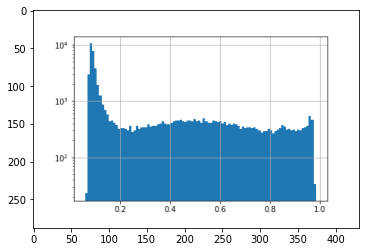

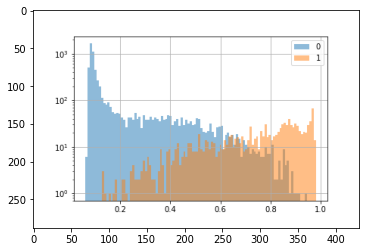

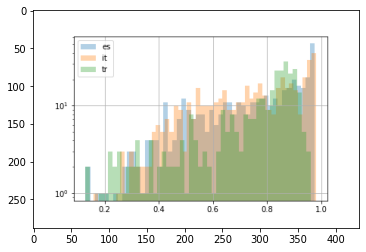

In [16]:
!gsutil -m cp {gcs_path}/*.png .
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('sub_hist.png')
_ = plt.imshow(img)
plt.show()
img = mpimg.imread('valid_hist.png')
_ = plt.imshow(img)
plt.show()
img = mpimg.imread('valid_toxic_hist.png')
_ = plt.imshow(img)

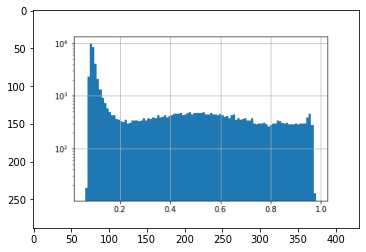

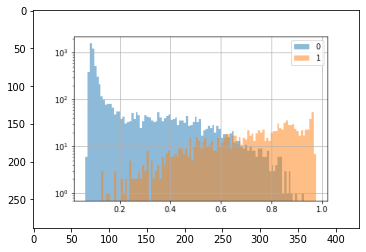

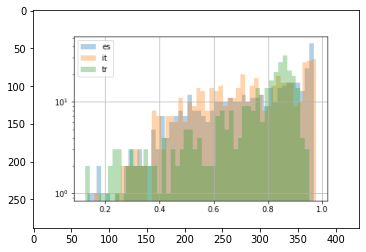

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('sub_hist_test.png')
_ = plt.imshow(img)
plt.show()
img = mpimg.imread('valid_hist_test.png')
_ = plt.imshow(img)
plt.show()
img = mpimg.imread('valid_toxic_hist_test.png')
_ = plt.imshow(img)